# Dyad analysis of Carolyn's data

In [44]:
library(tidyverse)
library(stringr)
library(robR)
library(lme4)
library(lmerTest)

## Load data and merge data

In [45]:
setwd("C:/Users/rober/Google Drive/MIND_2018")

# load brain data
cp_brain<- read.csv("all_pairs_data_scaled_Study1_anonymized.csv", stringsAsFactors = FALSE)

# load personality data
cp_anon_pers <- read.csv("anon_pers_data.csv",stringsAsFactors = FALSE)


items <- pers %>%  select(-Extraversion, -Agreeableness, -Conscientiousness, -Neuroticism, -Openness, -anon_id)  

brain_ids <- unique(c(as.character(cp_brain$anon_subj1), as.character(cp_brain$anon_subj2)))


brain_ids_df <- data.frame(anon_id = brain_ids)

brain_pers <- inner_join(brain_ids_df, cp_anon_pers) %>% arrange(anon_id)

brain_pers_items <- brain_pers %>% select(-Extraversion, -Agreeableness, -Conscientiousness, -Neuroticism, -Openness, -anon_id)


Joining, by = "anon_id"
Warning message:
"Column `anon_id` joining factor and character vector, coercing into character vector"

## Define helper functions
These functions help with plotting the off diagonal DSM.

In [46]:
# Mask DSM with NAs of the off-diagonal for gg-plotting ----------------------------
dsm_mask <- function(dsm, lower=FALSE, melt=TRUE){
  require(reshape2)
  
  # Don't melt output
  if(melt==FALSE){
    if(lower==FALSE){
      mat <- as.matrix(dsm)
      mat[lower.tri(mat,diag = TRUE)] <- NA
      mat
    }
    else{
        mat <- as.matrix(dsm)
        mat[upper.tri(mat,diag = TRUE)] <- NA
        mat
      }
  }
  
  # Melt output for plotting
   else{
      if(lower==FALSE){
       mat <- as.matrix(dsm)
       mat[lower.tri(mat,diag = TRUE)] <- NA
       mat_m <- melt(mat)
       mat_m$Var1 <- as.factor(mat_m$Var1)
       mat_m$Var2 <- as.factor(mat_m$Var2)
       mat_m$Var2 <- factor(mat_m$Var2, levels = rev(levels(mat_m$Var2)))
       mat_m
     }
     else{
       mat <- as.matrix(dsm)
       mat[upper.tri(mat,diag = TRUE)] <- NA
       mat_m <- melt(mat)
       mat_m$Var1 <- as.factor(mat_m$Var1)
       mat_m$Var2 <- as.factor(mat_m$Var2)
       mat_m$Var2 <- factor(mat_m$Var2, levels = rev(levels(mat_m$Var2)))
       mat_m
     } 
   }
}


# Make DSM plot -------------------------------------------------------
dsm_plot <- function(df,col_n=8, color_dir = 1, rev_fac=FALSE){
  
  require(ggplot2)
  library(colorRamps)
  library(viridis)
  
  if(rev_fac==FALSE){
    df <- df[which(is.na(df[,3])==FALSE),]
    df[,1] <- factor(df[,1])
    df[,2] <- factor(df[,2])
    df$Var1 <- df[,1]
    df$Var2 <- df[,2]
    df$value <- df[,3]
    mytheme <- theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank())
    ggplot(df, aes(Var1,Var2,fill=value)) + geom_raster() + theme_minimal() + mytheme + 
      scale_fill_gradientn(colors = magma(col_n, direction = color_dir),name = "Dissimilarity") + xlab("") + ylab("")
  }
  
  else{
    df <- df[which(is.na(df[,3])==FALSE),]
    df[,1] <- factor(df[,1])
    df[,2] <- factor(df[,2])
    df[,2] <- factor(df[,2],levels = rev(levels(df[,2])))
    df$Var1 <- df[,1]
    df$Var2 <- df[,2]
    df$value <- df[,3]
    mytheme <- theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank(), axis.text.x = element_text(angle = 300, hjust = 0))
    ggplot(df, aes(Var1,Var2,fill=value)) + geom_raster() + theme_minimal() + mytheme + 
      scale_fill_gradientn(colors = magma(col_n, direction = color_dir),name = "Dissimilarity") + xlab("") + ylab("")
  }
}






## Calculate DSMs for traits

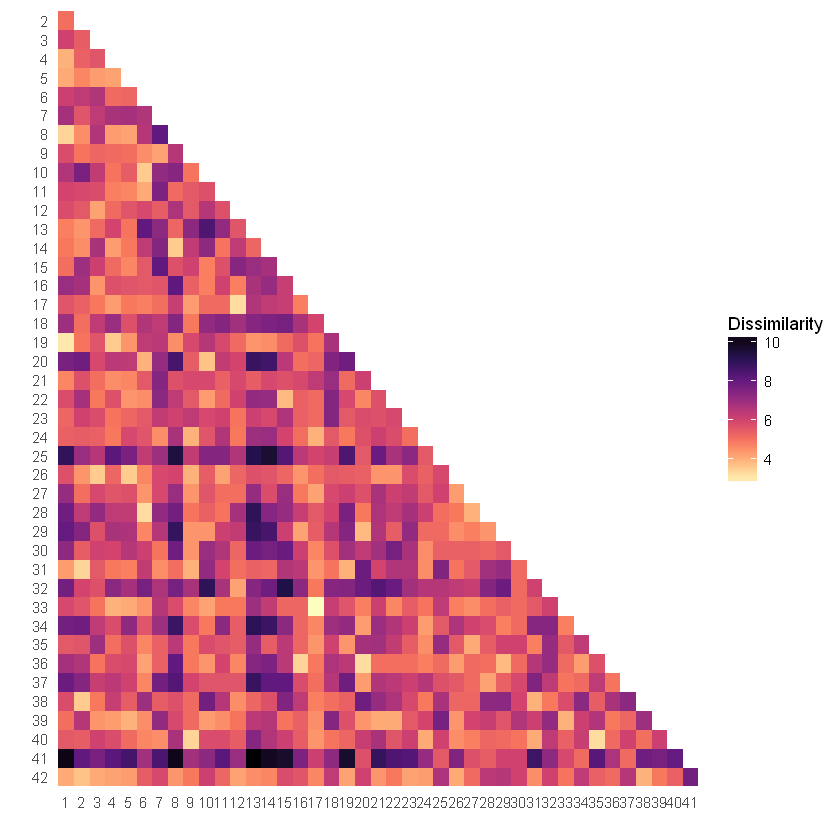

In [47]:
# Calculate dissimilarities
d_items <- dist(brain_pers_items)
d_extra <- dist(brain_pers$Extraversion)
d_open <- dist(brain_pers$Openness)
d_neurotic <- dist(brain_pers$Neuroticism)
d_consci <- dist(brain_pers$Conscientiousness)
d_agree <- dist(brain_pers$Agreeableness)


# Plot full personality DSM
dsm_mask(d_items) %>% dsm_plot(color_dir = -1)

## Merge DSMs for traits with dyadic fMRI data

In [48]:
# 
personality_dsm <- data.frame(all_trait_dist = as.numeric(as.matrix(d_items)))
personality_dsm$open_dist <- as.numeric(as.matrix(dist(brain_pers$Openness)))
personality_dsm$consci_dist <- as.numeric(as.matrix(dist(brain_pers$Conscientiousness)))
personality_dsm$extra_dist <- as.numeric(as.matrix(dist(brain_pers$Extraversion)))
personality_dsm$agree_dist <- as.numeric(as.matrix(dist(brain_pers$Agreeableness)))
personality_dsm$neurotic_dist <- as.numeric(as.matrix(dist(brain_pers$Neuroticism)))

personality_dsm$sub1 <- rep(brain_pers$anon_id, 42)

sub2 <- vector()
for(i in brain_pers$anon_id){
  
  r <- rep(i, 42)
  sub2 <- c(sub2, r)
  
}


personality_dsm$sub2 <- sub2

personality_dsm$anon_dyad <- str_c(personality_dsm$sub1,personality_dsm$sub2, sep = '_')


dyad_df <- inner_join(personality_dsm, cp_brain) 
dyad_df$soc_dist2 <- ifelse(dyad_df$soc_dist ==5, 4, dyad_df$soc_dist)
dyad_df_cor <- dyad_df %>% select(-sub1, -sub2, -anon_subj1, -anon_subj2, -anon_dyad)  
  
corall <- cor(dyad_df_cor)

Joining, by = "anon_dyad"


## Plot the disimilarites per social distance
These plots are just to get a sense of the data but shouldn't be interpreted due to the nested structure of the data. Prints plot for full raw peronality trait dissimilarity as well as the summaried dissimilarites for each of the Big 5 traits.

[1] "Using between-subject SEM error bars"
[1] "Using between-subject SEM error bars"
[1] "Using between-subject SEM error bars"
[1] "Using between-subject SEM error bars"
[1] "Using between-subject SEM error bars"
[1] "Using between-subject SEM error bars"


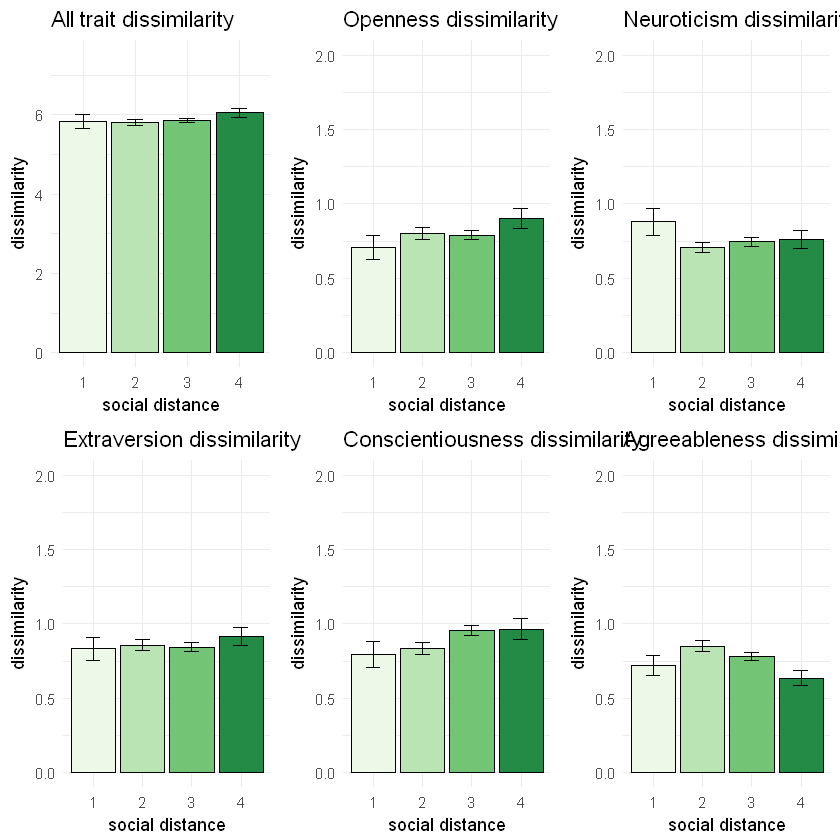

In [49]:
all <- ggbar.maker(dyad_df$all_trait_dist, dyad_df$soc_dist2, palette = 'Greens') + 
  coord_cartesian(ylim = c(0,7.5)) + 
  labs(title = "All trait dissimilarity", x = "social distance", y = "dissimilarity") +
  theme_minimal() +
  theme(legend.position = "none")

extra <- ggbar.maker(dyad_df$extra_dist, dyad_df$soc_dist2, palette = 'Greens') + 
  coord_cartesian(ylim = c(0,2)) + 
  labs(title = "Extraversion dissimilarity", x = "social distance", y = "dissimilarity") +
  theme_minimal() +
  theme(legend.position = "none")

open <- ggbar.maker(dyad_df$open_dist, dyad_df$soc_dist2, palette = 'Greens') + 
  coord_cartesian(ylim = c(0,2)) + 
  labs(title = "Openness dissimilarity", x = "social distance", y = "dissimilarity") +
  theme_minimal() +
  theme(legend.position = "none")

consci <- ggbar.maker(dyad_df$consci_dist, dyad_df$soc_dist2, palette = 'Greens') + 
  coord_cartesian(ylim = c(0,2)) + 
  labs(title = "Conscientiousness dissimilarity", x = "social distance", y = "dissimilarity") +
  theme_minimal() +
  theme(legend.position = "none")

neurotic <- ggbar.maker(dyad_df$neurotic_dist, dyad_df$soc_dist2, palette = 'Greens') + 
  coord_cartesian(ylim = c(0,2)) + 
  labs(title = "Neuroticism dissimilarity", x = "social distance", y = "dissimilarity") +
  theme_minimal() +
  theme(legend.position = "none")

agree <- ggbar.maker(dyad_df$agree_dist, dyad_df$soc_dist2, palette = 'Greens') + 
  coord_cartesian(ylim = c(0,2)) + 
  labs(title = "Agreeableness dissimilarity", x = "social distance", y = "dissimilarity") +
  theme_minimal() +
  theme(legend.position = "none")

multiplot(all, extra, open, consci, neurotic, agree, cols = 3)


## Predicting personality dissimilarity from brain similarity per ROI

In [50]:
# Function to run lmer on each ROI
lmer_brain <- function(roi){
  exp <- paste("fit <- lmer(all_trait_dist ~", roi,"  + (1 + ",roi, "|sub1) +  (1 + ", roi,"|sub2), REML = FALSE,   data = dyad_df)")
  eval(parse(text = exp))
  pval <- summary(fit)[10][[1]][[10]]
  p <- paste(pval, roi)

print(p) 
}

# Run mix model on all brain areas and print the results
for(i in grep('ctx',ls(dyad_df_cor),value = TRUE)){
  lmer_brain(i)}

for(i in grep('Right',ls(dyad_df_cor),value = TRUE)){
     lmer_brain(i)}

for(i in grep('Right',ls(dyad_df_cor),value = TRUE)){
     lmer_brain(i)}

[1] "0.189584429935518 ctx.lh.bankssts"
[1] "0.638927221116257 ctx.lh.caudalanteriorcingulate"
[1] "0.924814259598467 ctx.lh.caudalmiddlefrontal"
[1] "0.10062141249025 ctx.lh.cuneus"
[1] "0.0889092048004703 ctx.lh.entorhinal"
[1] "0.483748948523223 ctx.lh.frontalpole"
[1] "0.457813438599843 ctx.lh.fusiform"
[1] "0.242865664110421 ctx.lh.inferiorparietal"
[1] "0.832656087917236 ctx.lh.inferiortemporal"
[1] "0.134416779126246 ctx.lh.insula"
[1] "0.89944389007551 ctx.lh.isthmuscingulate"
[1] "0.0359798821007935 ctx.lh.lateraloccipital"
[1] "0.657479200438881 ctx.lh.lateralorbitofrontal"
[1] "0.715024188848647 ctx.lh.lingual"
[1] "0.379346276747831 ctx.lh.medialorbitofrontal"
[1] "0.405442854745032 ctx.lh.middletemporal"
[1] "0.930544407749016 ctx.lh.paracentral"
[1] "0.761051374203199 ctx.lh.parahippocampal"
[1] "0.502955238161481 ctx.lh.parsopercularis"
[1] "0.596164965543441 ctx.lh.parsorbitalis"
[1] "0.466161057573593 ctx.lh.parstriangularis"
[1] "0.282862884506117 ctx.lh.pericalcarine